# Временные ряды

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Импортируем таблицу, переименовали столбцы и убрали ненужные.

In [10]:
df = pd.read_excel("csv_files/russian_bank.xlsx")
df = df.drop(0)
df = df.drop(1)
df = df.rename(columns={"Требования Банка России к кредитным организациям по кредитам (по оставшимся до погашения срокам), млн руб. (на начало дня)" : "datetime",
                           "Unnamed: 1" : "total requirements"})
df = df[["datetime", "total requirements"]]
df

,datetime,total requirements
2,2023-10-16 00:00:00,7411164.5
3,2023-10-13 00:00:00,7479860.57
4,2023-10-12 00:00:00,7317256.87
5,2023-10-11 00:00:00,1204392.68
6,2023-10-10 00:00:00,1159347.51
...,...,...
2180,2015-01-16 00:00:00,4500958.53
2181,2015-01-15 00:00:00,4549984.63
2182,2015-01-14 00:00:00,4421167.67
2183,2015-01-13 00:00:00,4458150.04


Преобразуем в формат, позволяющий работать с датами

In [11]:
df['datetime'] = pd.to_datetime(df['datetime'])
type(df['datetime'][2])

pandas._libs.tslibs.timestamps.Timestamp

Выводим информацию

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2183 entries, 2 to 2184
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            2183 non-null   datetime64[ns]
 1   total requirements  2183 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 34.2+ KB


Создаем строки с пропущенными датами

In [13]:
start_date = '2015-01-01'
end_date = '2023-10-16'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
full_date_df = pd.DataFrame({'datetime': date_range})
full_date_df
df = pd.merge(full_date_df, df, on='datetime', how='left')
df.head(15)

,datetime,total requirements
0,2015-01-01,NaN
1,2015-01-02,NaN
2,2015-01-03,NaN
3,2015-01-04,NaN
4,2015-01-05,NaN
5,2015-01-06,NaN
6,2015-01-07,NaN
7,2015-01-08,NaN
8,2015-01-09,NaN
9,2015-01-10,NaN


Делаем столбец datetime индексом

In [14]:
df.index = df['datetime']
del df['datetime']
df

,total requirements
datetime,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,NaN
...,...
2023-10-12,7317256.87
2023-10-13,7479860.57
2023-10-14,NaN


Используем bfill для заполнения пропущенных значений, так как для метода интерполяции недостаточно точек, а ffill не заполнит начальные значения. также bfill наиболее простой и быстрый и не нарушит апроксимацию данных.(он заполняет пропущенные значения значениями из следующей строки, будем считать, что в эти даты дополнительно кредиты не брались, это вполне логично, потому что банк наверняка бы документоривал все изменения)

In [15]:
df['total requirements'] = df['total requirements'].bfill()
df

,total requirements
datetime,
2015-01-01,4431673.18
2015-01-02,4431673.18
2015-01-03,4431673.18
2015-01-04,4431673.18
2015-01-05,4431673.18
...,...
2023-10-12,7317256.87
2023-10-13,7479860.57
2023-10-14,7411164.50


Text(0, 0.5, 'Total amount of requirements')

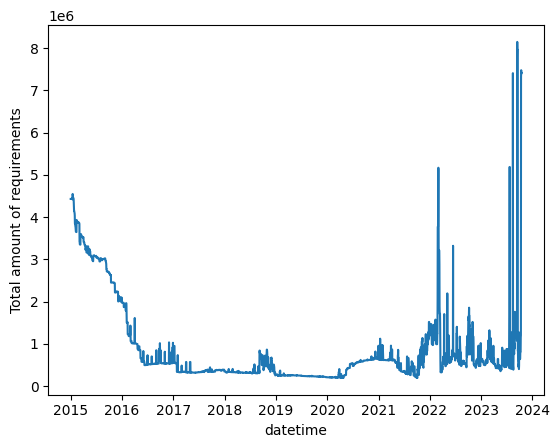

In [16]:
sns.lineplot(data=df, x=df.index, y=df['total requirements']) # визуализируем временной ряд
plt.ylabel('Total amount of requirements')

Как однозначноого тренда, так и однозначной сезонности не наблюдается.

Проведем тест на стационарность

In [17]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность
adft = adfuller(df)
print('p-value: ', adft[1])

p-value:  0.017097107801377243


P-value < 0.05, значит, этот ряд стационарный. По графику видно, что тренд у него выделить сложно, поэтому дополнительно приводить его к стационарному виду не имеет смысла.

Rоэффициент автокорреляции с лагом 1:

In [18]:
autocorrelation_lag1 = df['total requirements'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)

One Day Lag:  0.9501188451724579


In [19]:
autocorrelation_lag3 = df['total requirements'].autocorr(lag=14)#коэффициент автокорреляции с лагом 3
print("14 Day Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['total requirements'].autocorr(lag=30) #коэффициент автокорреляции с лагом 6
print("One Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['total requirements'].autocorr(lag=90) #коэффициент автокорреляции с лагом 9
print("Three Month Lag: ", autocorrelation_lag9)

14 Day Month Lag:  0.7959503302834243
One Month Lag:  0.8418820722476595
Three Month Lag:  0.7336726103306754


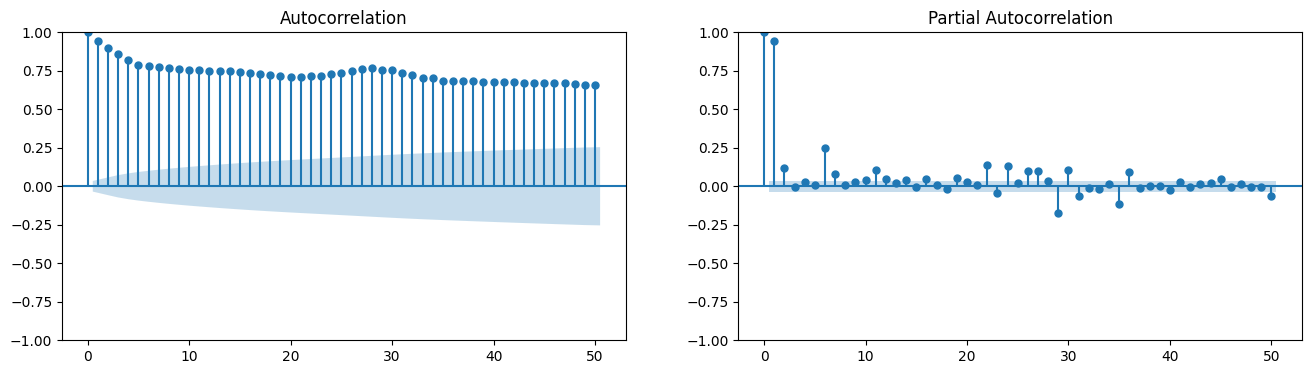

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df['total requirements'], lags=50, ax=axes[0])
plot_pacf(df['total requirements'], lags=50, ax=axes[1])
plt.show()

Так как определенного тренда у нас не было обнаружено, можно заметить, что резкого убывания нет, сезонности тоже не было, поэтому возрастания в середени можно просто классифицировать как разовый какой-то выброс из-за какого-то разового фактора, например кризиса или резкой инфляции в стране.

Разобьем выборку на две подвыборки: обучающую (до середины 2023 года)

In [21]:
df = pd.read_excel("csv_files/russian_bank.xlsx")
df = df.drop(0)
df = df.drop(1)
df = df.rename(columns={"Требования Банка России к кредитным организациям по кредитам (по оставшимся до погашения срокам), млн руб. (на начало дня)" : "datetime",
                           "Unnamed: 1" : "total requirements"})
df = df[["datetime", "total requirements"]]
df['datetime'] = pd.to_datetime(df['datetime'])
start_date = '2015-01-01'
end_date = '2023-10-16'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
full_date_df = pd.DataFrame({'datetime': date_range})
df = pd.merge(full_date_df, df, on='datetime', how='left')
df.index = df['datetime']

df['total requirements'] = df['total requirements'].bfill()
del df['datetime']
df
df['Date'] = df.index
train = df[df['Date'] < "2023-07-01"]
del train['Date']
train = train.rename(columns={'total requirements': 'train'})
train

,train
datetime,
2015-01-01,4431673.18
2015-01-02,4431673.18
2015-01-03,4431673.18
2015-01-04,4431673.18
2015-01-05,4431673.18
...,...
2023-06-26,457888.77
2023-06-27,507903.88
2023-06-28,457657.78


И тестовую (с середины 2023 года):

In [22]:
test = df[df['Date'] >= "2023-07-01"]
del test['Date']
test = test.rename(columns={'total requirements': 'test'})
test

,test
datetime,
2023-07-01,878377.30
2023-07-02,878377.30
2023-07-03,878377.30
2023-07-04,791368.34
2023-07-05,815788.99
...,...
2023-10-12,7317256.87
2023-10-13,7479860.57
2023-10-14,7411164.50


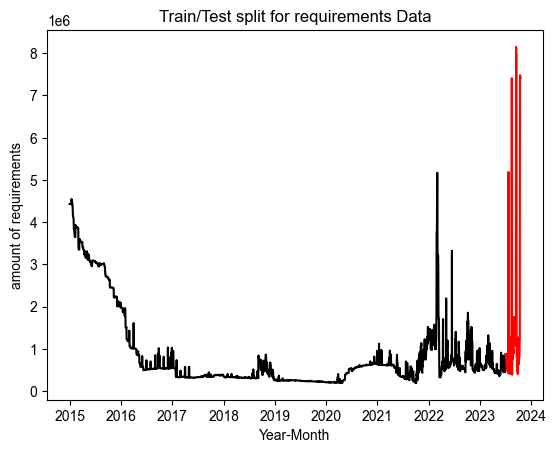

In [23]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split for requirements Data")
plt.ylabel("amount of requirements")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Поскольку у нас нет тренда или сезонности, предсказание может быть не точным, поэтому не будем выделять слишком большую часть для тестовой выборки иначе результаты будут слишком далеки от правды, потому что тенденция выбросов начинается примерно с 2022 года, для этого небольшую часть таких выбросов мы и включаем вместе с 2022 годом.

Построим модель ARIMA:

In [24]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=81493.165, Time=2.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81577.172, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81508.228, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=81498.715, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81575.438, Time=0.09 sec


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=81491.291, Time=1.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=81489.337, Time=0.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=81491.170, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=81490.542, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=81491.376, Time=2.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=81487.464, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=81496.899, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=81489.374, Time=1.45 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=81489.287, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=81488.231, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=81489.645, Time=1.59 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 14.581 seconds


Перебор останавливается на модели (0,1,2), которую и будем испольщовать в дальнейшем, поскольку она определилась как оптимальная, p = 0, q = 1, d = 2.

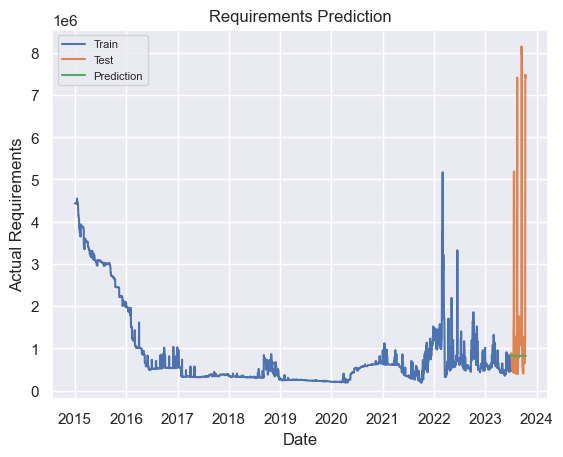

In [25]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Requirements Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Requirements')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Модель, очевидно получилась так себе по качеству, потому что по обучающей выборке сделать правильное предсказание было невозможно.

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=90088.034, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90380.936, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90292.405, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=90288.876, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90378.964, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=90162.906, Time=1.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=90159.179, Time=1.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=90083.232, Time=3.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=90139.473, Time=1.96 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=90078.135, Time=4.63 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=90133.030, Time=2.32 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=90081.680, Time=3.98 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=90078.473, Time=5.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=90107.011, Time=6.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=90101.734, Time=2.87

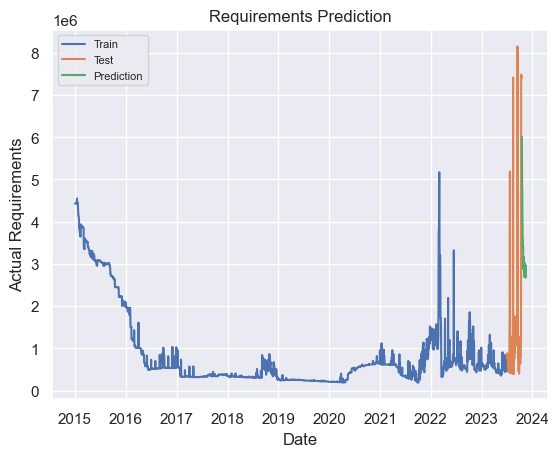

In [26]:
full_data = pd.concat([train['train'], test['test']], axis=0)
model = auto_arima(full_data, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(full_data)
forecast = model.predict(n_periods=30)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=test.index[-1], periods=31)[1:], columns=['Prediction'])
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Requirements Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Requirements')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Обучив модель сразу и на тестой и на обучающей выборках, предсказание на следующие 30 периолдов можно назвать вполне реалистичными, потому что участки быстрого роста обычно заканчиваются участками быстрого спада.